In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_validate
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, classification_report,
                             ConfusionMatrixDisplay, roc_curve, auc)
from sklearn.utils.class_weight import compute_class_weight



In [11]:
# Load and shuffle data to prevent ordered outcomes
data = pd.read_csv('D:\\MOOC.fi\\Jupyter\\EEG\\Dataset\\timefeature_data_final.csv')
data = data.sample(frac=1, random_state=42).reset_index(drop=True)  # Critical shuffle

# Verify class distribution after shuffling
print("Class distribution after shuffling:")
print(data['target'].value_counts(normalize=True))

# Split features and target
X = data.drop('target', axis=1)
y = data['target']

Class distribution after shuffling:
target
1    0.500061
0    0.499939
Name: proportion, dtype: float64


In [5]:
# First split: 80% train-val, 20% test
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, 
    test_size=0.2,
    stratify=y
)

print(f"\nTrain-val size: {len(X_trainval)}, Test size: {len(X_test)}")
print("Test set class distribution:", np.unique(y_test, return_counts=True))


Train-val size: 13105, Test size: 3277
Test set class distribution: (array([0, 1]), array([1638, 1639]))


In [6]:

param_grid = {
    'learning_rate': [0.05, 0.1],
    'max_iter': [100, 300],
    'max_depth': [3, None],
    'max_leaf_nodes': [15, 31],
    'min_samples_leaf': [20, 50],
    'l2_regularization': [0.0, 0.1],
    'max_bins': [128, 255],
    'early_stopping': [True]
}

model = HistGradientBoostingClassifier(
    class_weight='balanced',
    random_state=42,
    n_iter_no_change=10,
    validation_fraction=0.1,
    verbose=1
)

# Inner CV for grid search
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=inner_cv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_trainval, y_trainval)
best_model = grid_search.best_estimator_

Fitting 3 folds for each of 192 candidates, totalling 576 fits
Binning 0.033 GB of training data: 0.159 s
Binning 0.004 GB of validation data: 0.005 s
Fitting gradient boosted rounds:
Fit 180 trees in 3.117 s, (5580 total leaves)
Time spent computing histograms: 1.578s
Time spent finding best splits:  0.666s
Time spent applying splits:      0.101s
Time spent predicting:           0.019s



=== Final Test Set Performance ===
ROC AUC: 0.9983
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1638
           1       0.98      0.98      0.98      1639

    accuracy                           0.98      3277
   macro avg       0.98      0.98      0.98      3277
weighted avg       0.98      0.98      0.98      3277



<Figure size 800x600 with 0 Axes>

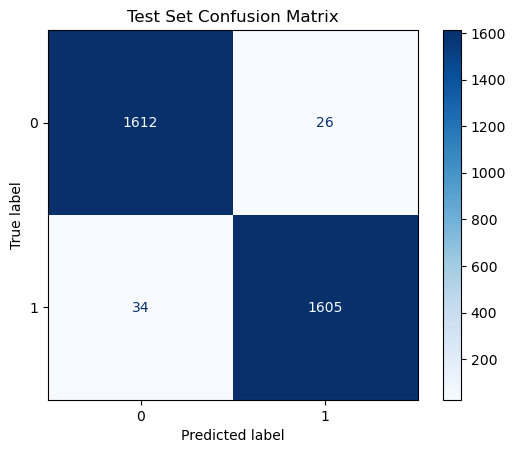

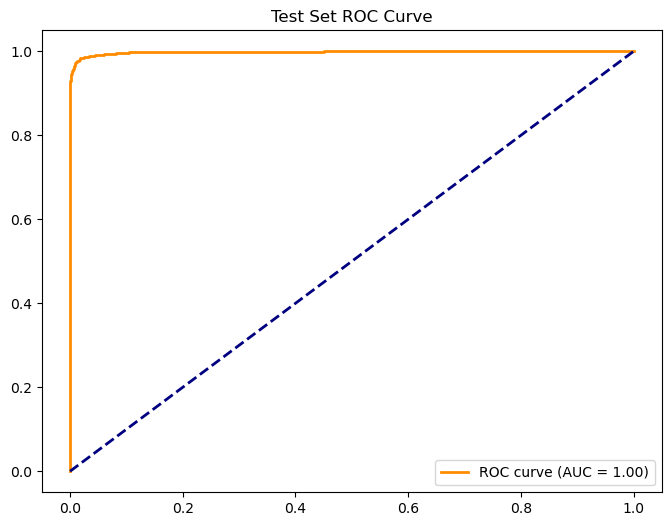

In [7]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    print("\n=== Final Test Set Performance ===")
    print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    plt.figure(figsize=(8, 6))
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues')
    plt.title('Test Set Confusion Matrix')
    plt.show()
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.title('Test Set ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    return y_proba

y_proba = evaluate_model(best_model, X_test, y_test)

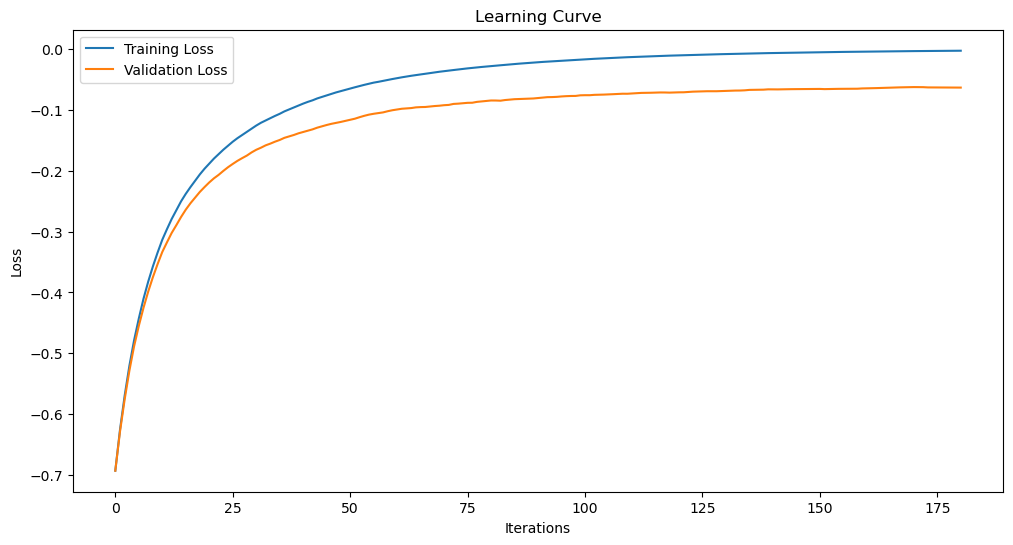

In [8]:
def plot_learning_curve(model):
    # Extract training history from the best model
    train_loss = model.train_score_
    val_loss = model.validation_score_
    
    plt.figure(figsize=(12, 6))
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Learning Curve')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_learning_curve(best_model)

In [12]:
print("\n=== Nested Cross-Validation ===")
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Using only train-val data for CV
cv_scores = cross_validate(
    grid_search.best_estimator_,
    X_trainval,
    y_trainval,
    cv=outer_cv,
    scoring=['roc_auc', 'accuracy', 'f1'],
    return_train_score=True,
    n_jobs=-1
)

print(f"Validation ROC AUC: {np.mean(cv_scores['test_roc_auc']):.4f} (±{np.std(cv_scores['test_roc_auc']):.4f})")
print(f"Validation F1: {np.mean(cv_scores['test_f1']):.4f}")


=== Nested Cross-Validation ===
Validation ROC AUC: 0.9972 (±0.0010)
Validation F1: 0.9781


In [13]:
print("\n=== Optimal Hyperparameters ===")
print(grid_search.best_params_)


=== Optimal Hyperparameters ===
{'early_stopping': True, 'l2_regularization': 0.0, 'learning_rate': 0.1, 'max_bins': 128, 'max_depth': None, 'max_iter': 300, 'max_leaf_nodes': 31, 'min_samples_leaf': 50}



=== SHAP Analysis ===


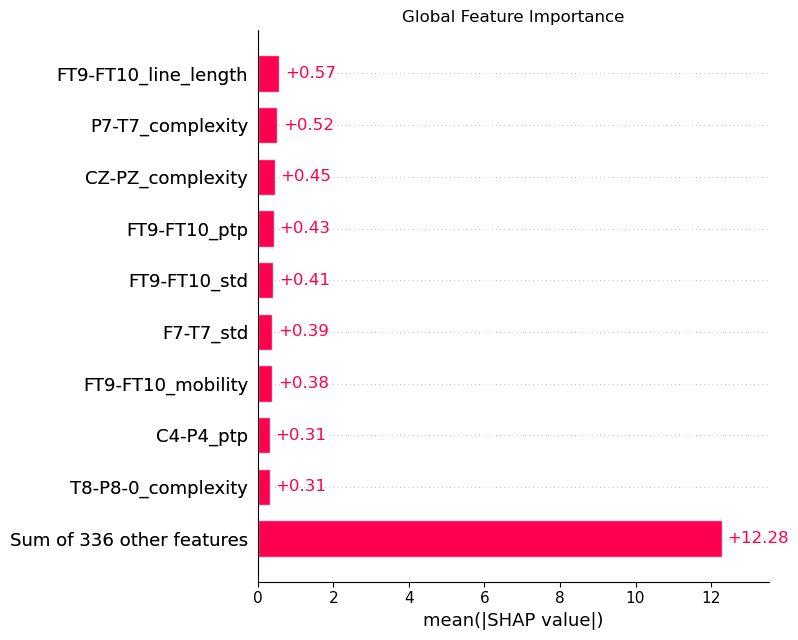

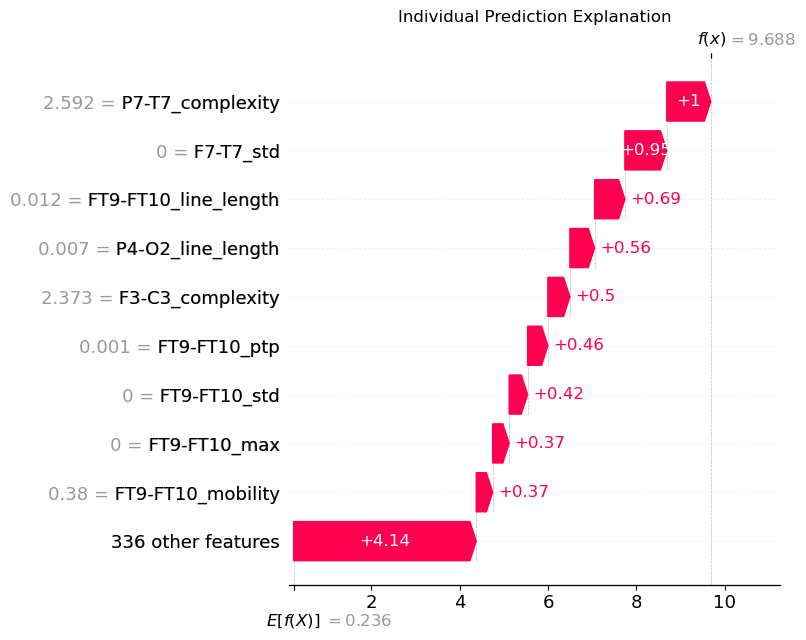

In [19]:
import shap

def shap_analysis(model, X, sample_size=1000):
    """Generate SHAP plots to explain model predictions"""
    print("\n=== SHAP Analysis ===")
    
    X_sample = X.sample(max(sample_size, len(X)), random_state=42)
    
    # Create explainer and calculate SHAP values
    explainer = shap.TreeExplainer(model)
    shap_values = explainer(X_sample)
    
    # Global feature importance
    plt.figure(figsize=(10, 6))
    shap.plots.bar(shap_values, show=False)
    plt.title("Global Feature Importance")
    plt.tight_layout()
    plt.show()
    
    # Individual sample explanation (first sample in the set)
    plt.figure(figsize=(10, 6))
    shap.plots.waterfall(shap_values[0], show=False)
    plt.title("Individual Prediction Explanation")
    plt.tight_layout()
    plt.show()

shap_analysis(best_model, X_test, sample_size=1000)

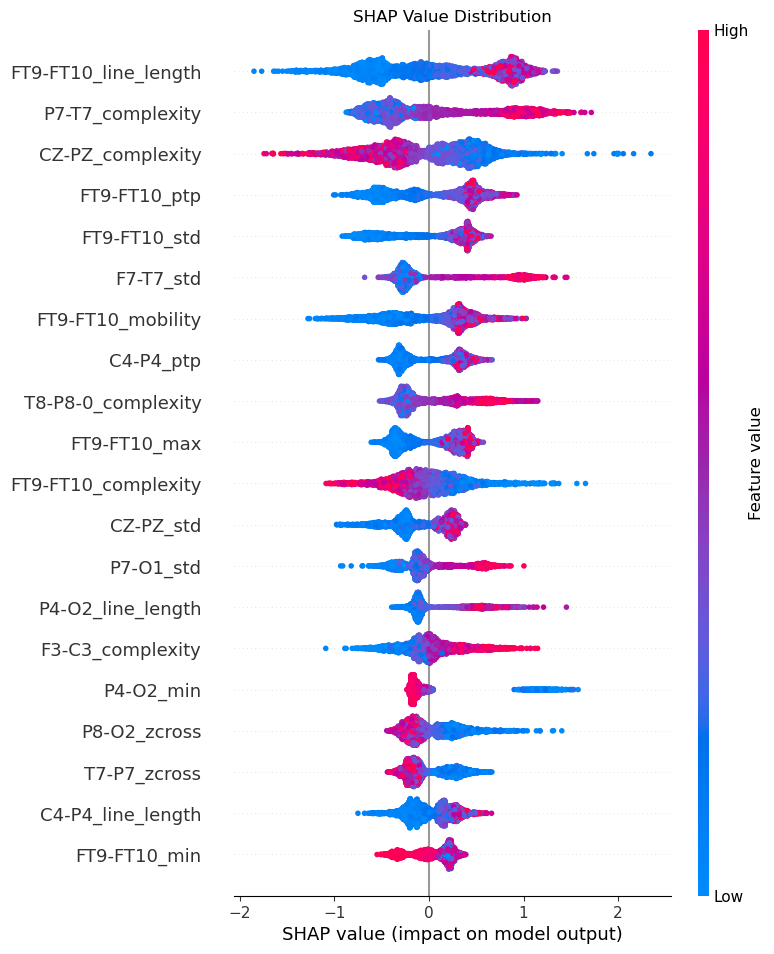

In [18]:
def shap_analysis(model, X):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)
    
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X, show=False)
    plt.title('SHAP Value Distribution')
    plt.show()
shap_analysis(best_model, X_test)